### Adding Emotion and Mouth position columns to the dataframe. Data prep and only for RADIATE data set. Also note Calm, exuberant, and N/A are dropped here to match the virtual dataset for comparing purposes.

In [ ]:
import pandas as pd

df = pd.read_csv('RADIATE_Color_Faces_AU.csv', index_col=0)

df["emotion"] = df.index
df["emotion"] = df["emotion"].str.extract(r'.*_(.*).bmp')
# extract (.)(.) from the emotion column
temp = df["emotion"].str.extract(r'(.)(.)')

df["emotion"] = temp[0]
df["mouth"] = temp[1]

# if emotion is A, then replace A with angry
df["emotion"] = df["emotion"].replace("A", "angry")
# if emotion is C, then replace H with calm
df["emotion"] = df["emotion"].replace("C", "calm")
# if emotion is D, then replace D with disgust
df["emotion"] = df["emotion"].replace("D", "disgust")
# if emotion is F, then replace F with fear
df["emotion"] = df["emotion"].replace("F", "fear")
# if emotion is H, then replace H with happy
df["emotion"] = df["emotion"].replace("H", "happy")
# if emotion is N, then replace N with neutral
df["emotion"] = df["emotion"].replace("N", "neutral")

df = df[df['emotion'] != 'calm']

# if emotion is S, and mouth is U in the same row, then replace S with surprise
df.loc[(df["emotion"] == "S") & (df["mouth"] == "U"), "emotion"] = "surprise"
# if emotion is S, and mouth is not U in the same row, then replace S with sad
df.loc[(df["emotion"] == "S") & (df["mouth"] != "U"), "emotion"] = "sad"

# if mouth is O, then replace O with open
df["mouth"] = df["mouth"].replace("O", "open")
# if mouth is C, then replace C with closed
df["mouth"] = df["mouth"].replace("C", "closed")
# if mouth is U, then replace U with N/A
df["mouth"] = df["mouth"].replace("U", "N/A")
# if mouth is E, then replace E with exuberant
df["mouth"] = df["mouth"].replace("E", "exuberant")

df = df[df['mouth'] != 'exuberant']
df = df[df['mouth'] != 'N/A']

# create an emotionID column
df["emotionID"] = df["emotion"].astype('category').cat.codes

# create a mouthID column
df["mouthID"] = df["mouth"].astype('category').cat.codes

# put the emotion and emotionID columns and mouth and mouthID columns at the beginning of the dataframe
df = df[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

# print first 15 rows
print(df.head(15))

### Data prep for UIBVFED Dataset. Only open and closed mouths are considered.

In [ ]:
import numpy as np
df2 = pd.read_csv('UIBVFED_AU.csv', index_col=0)
df2

In [4]:
df2["emotion"] = df2.index
df2["emotion"] = df2["emotion"].str.extract(r'_(\w+)\.png')

df2['mouth'] = df2['emotion']
df2['mouth'] = df2['mouth'].replace(['EnragedShouting', 'Terror', 'VeryFrightened', 'FalseLaughter1', 'FalseLaughter2', 'Laughter', 'SmilingOpenMouthed', 'UproariousLaughter', 'CryingOpenMouthed', 'Suprise'], 'open')
df2['mouth'] = np.where(df2['mouth'] != 'open', 'closed', df2['mouth'])

df2["emotion"] = df2["emotion"].replace(['EnragedCompressedLips', 'EnragedShouting', 'Mad', 'SternnessAnger'], "angry") #0
df2["emotion"] = df2["emotion"].replace('Surprise', "surprise") #7
df2["emotion"] = df2["emotion"].replace(['Disdain', 'Disgust', 'PhysicalRepulsion'], 'disgust') #2
df2["emotion"] = df2["emotion"].replace(['Afraid', 'Terror', 'VeryFrightened', 'Worried'], "fear") #3
df2["emotion"] = df2["emotion"].replace(['AbashedSmile', 'DebauchedSmile', 'EagerSmile', 'FalseLaughter1', 'FalseLaughter2',
                                         'FalseSmile', 'IngratiatingSmile', 'Laughter', 'MelancholySmile', 'SlySmile', 'SmilingClosedMouth', 'SmilingOpenMouthed', 'StifledSmile', 'UproariousLaughter'], "happy") #4
df2["emotion"] = df2["emotion"].replace(['CryingClosedMouth', 'CryingOpenMouthed', 'Miserable', 'NearlyCrying', 'Sad', 'SuppressedSadness'], "sad") #6
df2["emotion"] = df2["emotion"].replace('Neutral', 'neutral') #5

df2['emotionID'] = df2['emotion']
df2['mouthID'] = df2['mouth']

# create an emotionID column
df2["emotionID"] = df2["emotion"].astype('category').cat.codes

# create a mouthID column
df2["mouthID"] = df2["mouth"].astype('category').cat.codes

df2 = df2[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df2.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

#print(df2[df2.iloc[:, 0].str.contains('sad')])

### Visualize the frequency of emotions in data set. Can change df -> df2 in the code and viceversa to look at each dataset.



happy       280
sad         120
fear         80
angry        80
disgust      60
neutral      20
surprise     20
Name: emotion, dtype: int64


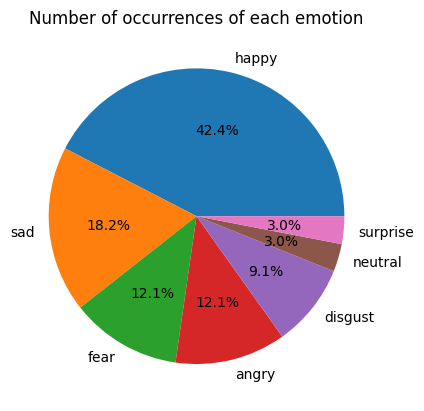

In [6]:
# count the number of occurrences of each emotion in the dataset
emotion_counts = df2["emotion"].value_counts()
print(emotion_counts)

# plot a pie chart of the number of occurrences of each emotion in the dataset
import matplotlib.pyplot as plt
emotion_counts.plot.pie(autopct="%.1f%%")
plt.title("Number of occurrences of each emotion")
plt.ylabel("")
plt.show()

### Classifier

In this file, we are training a model on the UIBVFED data set and testing accuracies across both.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train test split
X = df2.drop(columns=["emotion", "emotionID", "mouth"])
y = df2["emotionID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
emotion_counts_test = y_test.value_counts()
print(emotion_counts_test)

training 4 different models and looking at accuracy of each through heat maps and simple output.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# find the best classifier for the dataset, set the random_state to 42
classifiers = [
    RandomForestClassifier(random_state=12),
    SVC(random_state=12),
    DecisionTreeClassifier(random_state=12),
    XGBClassifier(random_state=12)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))

    # plot how many times emotion is predicted correctly
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    # put ticks at the center of each cell
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_labels)
    plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_labels, rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(clf.__class__.__name__)
    plt.show()

Feature Importance






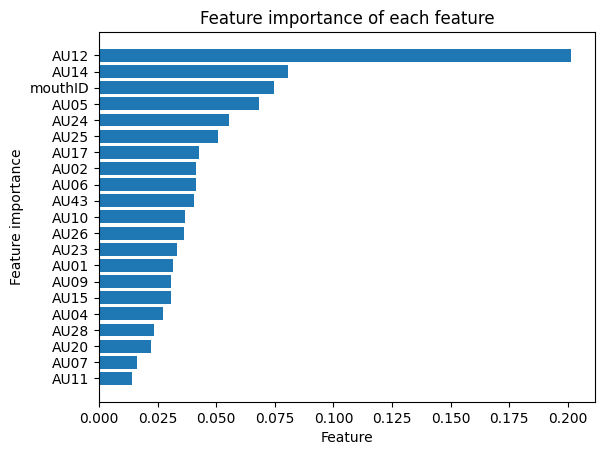

In [16]:
import matplotlib.pyplot as plt

# feature importance
feature_importance = clf.feature_importances_

# plot feature importance
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance of each feature")
plt.show()

### Code that tests accuracy of RADIATE dataset on the UIBVFED trained models. Could further visualize data here.


In [17]:
X1 = df.drop(columns=["emotion", "emotionID", "mouth"])
y1 = df["emotionID"]
for clf in classifiers:
  y_pred1 = clf.predict(X1)
  print(clf.__class__.__name__, "Accuracy:", accuracy_score(y1, y_pred1))

RandomForestClassifier Accuracy: 0.39197530864197533
SVC Accuracy: 0.36882716049382713
DecisionTreeClassifier Accuracy: 0.31712962962962965
XGBClassifier Accuracy: 0.375
